In [1]:
from mm import *

In [2]:
from dataclasses import dataclass

In [3]:
def query(q,url='http://85.193.83.20:8123',format=True,**kwargs):
    if format:
        return pd.read_csv(BytesIO(r.post(url=url,
                data=(q+'\nFORMAT CSVWithNames').encode('utf-8'),
                auth= (os.getenv('CRYPTO_ETL_USER'),os.getenv('CRYPTO_ETL_PASSWORD'))
                ).content),**kwargs)
    
    else:
        return r.post(url=url,
                data=q.encode('utf-8'),
                auth=(os.getenv('CRYPTO_ETL_USER'),os.getenv('CRYPTO_ETL_PASSWORD')))
    

In [4]:
def rsi_calc(df,w=14):
    wsa = (100 - 100 / df.pct_change().where(lambda x: x>0).rolling(w,1).mean().div(df.pct_change().where(lambda x: x<0).rolling(w,1).mean().abs()).add(1))
    rsi = wsa.shift(1).mul(w-1).add(wsa).div(w)
    return rsi

In [5]:
def check_cross(data,value_col ='avg_price' ,rolling_fast = 10,rolling_slow = 100, cross_window = 10,**kwargs ):
    zz = data.copy()
    zz['r_fast'] = zz[value_col].rolling(rolling_fast,1).mean()
    zz['r_slow'] = zz[value_col].rolling(rolling_slow,1).mean()

    zz['rolling_diff'] = zz['r_fast'] - zz['r_slow']

    zz['is_buy_cross'] = (zz['rolling_diff'] >0) & (zz['rolling_diff'].shift(cross_window) < 0)

    return (zz['is_buy_cross'].iloc[-1])# & all(zz[value_col].iloc[-cross_window:] < np.minimum(zz['r_fast'].iloc[-cross_window],zz['r_slow'].iloc[-cross_window]))

In [6]:
qq = query('''
select toStartOfInterval(toDateTime(trade_time/1000), interval 1 minute) as t, 
count(trade_id)  trades_count,
avg(price)  as avg_price
from crypto.binancews_trade
where t>'2022-01-21'
group by t
order by t

''').astype({'t':'datetime64[ms]'}).set_index('t')

In [25]:
@dataclass
class TradeBotBase:
    '''
    Базовый каркас проверки моделей торговли, возможно будет в будущем каркасом бота\n
    Создаем Сущность которая будет внутри себя иметь все основные эдементы для торговли\n
    Закладываем то, что понадобится для всех моделей - базовые параметры + общий функционал
    
    Класс не содержет стратегий покупки, т.к. они будут формироваться дочерними классами\n
    Главным способом взаимодействия будет являться модуль models_result\n
    В него дочерние классы будут писать свои результаты и по ним уже модуль fetch_deals будет совершать операции

    '''
    name : str = 'Vasya'
    deposit : int = 100000 # наш начальный гонорар \ при первом приближении покупаем по 1 целой монетке
    trade_fee : float = .001 # торговая пошлина
    profit : float = .001 # Величина минимального профита для продажи
    stoploss : float = 0.05 # величина стоплоса \ простой стоплосс
    
    def __post_init__(self):
        '''
        Задаем базовые параметры моделек
        '''
        self.models_result = {} # собираем решения о покупке от нескольких стратегий
        self.coin_pool = {} # храним информацию о том, за сколько и когда мы купили монетку
        self.deals_dict = {'sell':[],'buy':[]} # храним простую статистику покупок \ продаж *даты*
        self.cash_flow = {} # статистика по тоталу нашего кошелька после каждой сделки
        self.ttl_profit = defaultdict(int) # статистика нашего профита после каждой сделки

    def get_data(self,df):
        '''
        df : DataFrame \n
        Передаем сюда данные по ценам.\n
        индекс - datetime в минутном разрезе\n
        значения - среднее значение по торгам \ в свечке
        '''
        self.df = df
        self.current_price = df[-1] # запоминаем цену и даты, часто будем переиспользовать
        self.current_dt = df.index[-1]


    def buy (self):
        '''
        Атомарная функция покупки и записи статистики\n
        Является кнопкой "Тратить деньги"
        
        '''
        self.coin_pool[self.current_dt] = self.current_price # Забираем монетку в кошель и знаем о том когда и за сколько мы ее купили
        self.deposit -= self.current_price*(1 + self.trade_fee) # За покупку мы снимаем с кошеля стоимость монеты + пошлину
        self.cash_flow [self.current_dt] = self.deposit # Запоминаем наш cash flow для анализа и статистики
        self.deals_dict['buy'].append(self.current_dt) # Запоминаем когда сделали сделку для статистики
        
        return self

    def sell (self,order):
        '''
        Атомарная функция продажи и записи статистики\n
        Является кнопкой "Получеть деньги"
        
        '''
        self.deposit += self.current_price*(1 - self.trade_fee) # За продажу мы снимаем с кошеля стоимость монеты + пошлину
        self.deals_dict['sell'].append(self.current_dt)
        self.cash_flow [self.current_dt] = self.deposit
        self.ttl_profit[self.current_dt] += self.current_price*(1 - self.trade_fee) - self.coin_pool[order]*(1 + self.trade_fee) # Запоминаем наш профит со сделки
        del self.coin_pool[order] # Убираем монетку с нашего кошеля, которую мы продали
        return self

    def check_sell(self,order):
        '''
        Функция проверки целесообразности продажи\n
        В себе так же содержит stoploss\n
        '''
        profit_pct = self.profit

        if self.current_price / self.coin_pool[order] > 1 + profit_pct: # если продажа монетка дороже на n% стоимости ее покупки то продаем
            self.sell(order)
            
        elif self.current_price / self.coin_pool[order] < 1 - self.stoploss: # если монетка подешевела более чем на n% то продаем
            self.sell(order)

        return self


    def fetch_deals(self,is_any_strategy=True):
        '''
        Общая функция проверки состояния последнего поступившего сигнала\n
        Т.е. функция принятия решения по продажам\покупкам в момент времени
        
        '''
        buy_datetimes = list(self.coin_pool.keys()) #Получаем список монеток которые у нас есть в кошеле

        for deal in buy_datetimes:
            self.check_sell(deal) # Для каждой из них проверяем - не стоит ли продать или стоплосснуть

        if self.deposit > self.current_price: # В целом если у нас есть деньги на покупку по текущей стоимости - начинаем проверки на покупку

            if is_any_strategy:
                if any(self.models_result.values())==True: # Если хотя бы одна стратегия сработата, то инициируем покупку
                    self.buy()
            else:
                if all(self.models_result.values())==True: # Если все стратегии сработати, то инициируем покупку
                    self.buy()
        return self
    

In [28]:
@dataclass
class TradeBotRsi(TradeBotBase):
    '''
    Модель простой стратегии для примера\n
    Наследуем все основные свойства базового класса для консистентности \n

    Основная задача модуля - добавить функцию, которая на вход получит информацию\n
    На выходе она должна добавить в словарь models_result свое название и решение о покупке виде True \ False

    Последовательность обработки данных :
    1) get_data - для получение актуального состояния модели
    2) *model*_check() - рассчет и обработка данных для принятия решений
    3) fetch_deals - для обработки логики принятия решений с учетом ответа модели
    '''    
    def rsi_check(self,rsi_thr=20):
        self.models_result['rsi_check'] = rsi_calc(self.df)[-1]<rsi_thr
        return self.models_result


In [29]:
@dataclass
class TradeBotCross(TradeBotBase):
        
    def cross_check(self):
        self.models_result['cross_check'] = check_cross(self.df.to_frame())
        return self.models_result


In [31]:
# Основной этап тестирования - определяем наши стратегии в виде объектов
# Имитируем ежедневный прирост информации , подавай порционно данные с интервалом 1 минута
# Ну и выполняем основные шаги наших роботиков

rsi_bot = TradeBotRsi(name = 'Oleg',stoploss=0.02,profit=0.01)
cross_bot = TradeBotCross(name = 'Vitek',stoploss=0.02,profit=0.01)

for i in tqdm(range(1,1000)):

    rsi_bot.get_data(qq['avg_price'].iloc[:i])
    rsi_bot.rsi_check()
    rsi_bot.fetch_deals()

    cross_bot.get_data(qq['avg_price'].iloc[:i])
    cross_bot.cross_check()
    cross_bot.fetch_deals()


100%|██████████| 999/999 [00:05<00:00, 184.30it/s]


In [38]:
# Инфа сколько по итогу мы ушатали денег ;)
print(f'rsi_profit : {np.sum(list(rsi_bot.ttl_profit.values())):.0f}\ncross_profit : {np.sum(list(cross_bot.ttl_profit.values())):.0f}')

rsi_profit : -1409
cross_profit : -5005


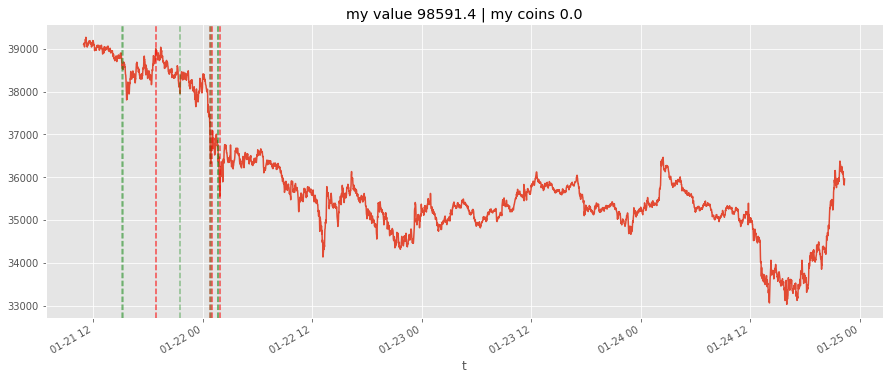

In [39]:
# Визуальный ряд с инфой где мы закупались и где продавали
qq['avg_price'].iloc[:5000].plot(title=f'my value {rsi_bot.deposit:.1f} | my coins {np.sum(list(rsi_bot.coin_pool.values()))}')
[plt.axvline(dt,linestyle='--',color='g',alpha=.4) for dt in rsi_bot.deals_dict['buy']];
[plt.axvline(dt,linestyle='--',color='r',alpha=.4) for dt in rsi_bot.deals_dict['sell']];


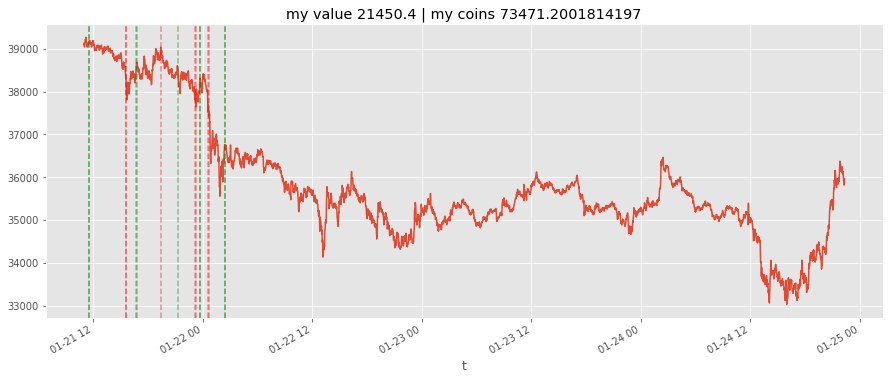

In [40]:
qq['avg_price'].iloc[:5000].plot(title=f'my value {cross_bot.deposit:.1f} | my coins {np.sum(list(cross_bot.coin_pool.values()))}')
[plt.axvline(dt,linestyle='--',color='g',alpha=.4) for dt in cross_bot.deals_dict['buy']];
[plt.axvline(dt,linestyle='--',color='r',alpha=.4) for dt in cross_bot.deals_dict['sell']];


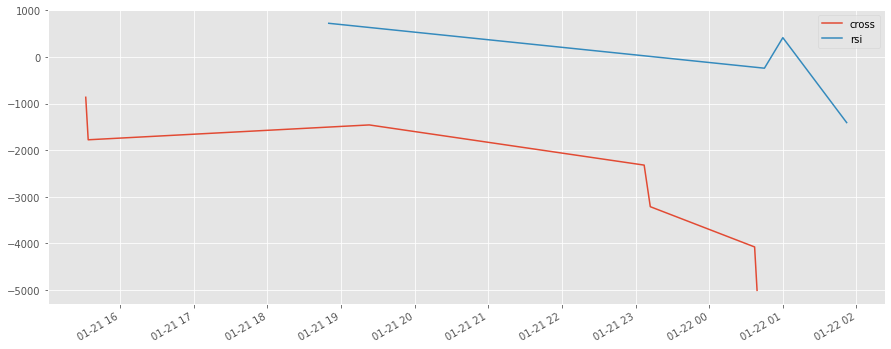

In [44]:
# График профита
pd.Series(cross_bot.ttl_profit).cumsum().plot()
pd.Series(rsi_bot.ttl_profit).cumsum().plot()
plt.legend(['cross','rsi'])